In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot

from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score, f1_score, auc
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_excel('data.xlsx')

In [3]:
df

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,1,2,1,5,1,0,0,0,1,0,...,10,0,3,5,0,1,0,0,0,0
1,1,1,1,4,0,0,1,0,0,0,...,6,2,3,9,0,1,0,1,0,1
2,1,2,1,1,1,0,1,0,0,0,...,7,0,2,10,1,1,0,0,0,1
3,1,3,2,1,0,0,0,0,1,0,...,7,1,7,6,0,0,0,0,0,0
4,1,5,1,3,1,0,0,1,0,0,...,5,0,3,11,1,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0,0,1,3,0,0,1,0,0,0,...,7,1,4,10,0,0,1,0,0,0
19996,0,0,1,6,1,0,0,0,1,0,...,8,2,4,5,1,1,1,0,0,0
19997,0,5,1,0,1,-1,0,1,0,0,...,6,0,2,7,1,0,1,0,0,0
19998,0,2,1,8,0,0,0,0,0,1,...,2,1,1,14,0,0,1,0,1,0


Let's standardize dataset

In [4]:
scaler = StandardScaler()

scaler.fit(df.values)

df_standardized = pd.DataFrame(scaler.fit_transform(df.drop(['target'], axis=1)))
y = df['target']

Split our standardized dataset to train and test dataframes

In [5]:
x_train, x_test, y_train, y_test = tts(df_standardized, y, test_size=0.3)  # Cut off 30% of the sample for test

Fit and train the model

In [6]:
clf = LogisticRegression()

clf.fit(x_train, y_train)  # Обучаем модель
predictions = clf.predict(x_test)

pred_test_clf = clf.predict_proba(x_test)[:,1]
score1 = roc_auc_score(y_test, pred_test_clf)
score1  # Классификация без гиперпараметров, нормальные показатели

0.6238540632054552

In [7]:
score2 = clf.score(df_standardized, y)
score2  # Среднее значение точности, нормально

0.58835

In [8]:
score3 = average_precision_score(y_test, pred_test_clf)
score3  # PR оценка, неплохо 

0.6149027446144052

In [9]:
fpr, tpr, thresholds = roc_curve(y_test, pred_test_clf)
score4 = auc(fpr, tpr)
score4  # AUC оценка

0.6238540632054552

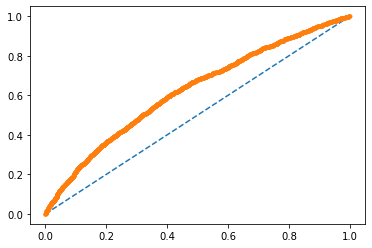

In [10]:
# Раз имеется площадь под кривой соответвущей величины, то можно сделать выводы, что модель обучена нормально
# Положительная принадлежность к классу, относительно частоты ложных срабатываний, предсказывается хорошо

fpr, tpr, thresholds = roc_curve(y_test, pred_test_clf)

pyplot.plot([0, 1], [0, 1], linestyle='--')
pyplot.plot(fpr, tpr, marker='.')
pyplot.show()

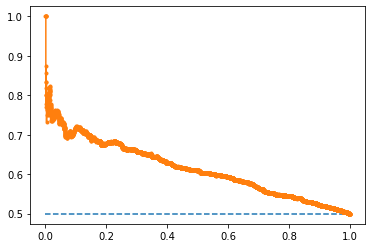

In [11]:
# Видно, что при возрастающей полноте точность падает. 
# Величина площади под кривой хорошая, следовательно, и модель хорошая

precision, recall, thresholds = precision_recall_curve(y_test, pred_test_clf)

pyplot.plot([0, 1], [0.5, 0.5], linestyle='--')
pyplot.plot(recall, precision, marker='.')
pyplot.show()

In [12]:
# Наблюдения по графикам кривых подтверждаются оценкой

print("ROC AUC " + str(score1) + "\nPR " + str(score3))

ROC AUC 0.6238540632054552
PR 0.6149027446144052


Part 2 - The Grid Search

In [13]:
params = {
    "penalty" : ["l1", "l2"],  # Подбор значений, которые неконфликтны с solver
    "C" : [100.0, 1.0, 0.01],  # Разброс
    "solver" : ["liblinear", "saga"],  # Они работают с l1 и l2 в penalty
    "max_iter" : [100, 300, 50],  # Разброс
}

In [14]:
Grid = GridSearchCV(clf, params, 'roc_auc', cv=10)
Grid.fit(x_train, y_train)  # Фитим

c:\python37\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\python37\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\python37\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\python37\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\python37\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [100.0, 1.0, 0.01], 'max_iter': [100, 300, 50],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [15]:
Grid.best_params_  # Смотрим наилучшие подобранные параметры

{'C': 0.01, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}

In [16]:
Grid.best_score_  # Оценка качества

0.6157547596644408

In [17]:
Grid.best_estimator_  # Подобранная оптимальная модель

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Recalculation of the score but considering the search on the grid

In [18]:
pred_test_grid = Grid.predict_proba(x_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, pred_test_grid)
score1_ = auc(fpr, tpr)
score1_

0.6267663012831959

In [19]:
score2_ = roc_auc_score(y_test, pred_test_grid)
score2_

0.6267663012831959

In [20]:
score3_ = average_precision_score(y_test, pred_test_grid)
score3_

0.617453819826377

Comparison

In [21]:
table = pd.DataFrame({
    'Score' : ['auc_score', 'roc_auc_score', 'pr_auc_score'],
    'No Grid Search' : [score4, score1, score3],
    'Grid Search' : [score1_, score2_, score3_],
    })

In [22]:
table['Difference'] = table['Grid Search'] - table['No Grid Search']

In [23]:
table

# Небольшой прирост в 0.002-0.0036
# В данной ситуации тяжело добиться большего прироста, но он хорош (конкретно здесь)
# Поиск по сетке - хорошая штука и имеет потенциал в других моделях

,Score,No Grid Search,Grid Search,Difference
0,auc_score,0.623854,0.626766,0.002912
1,roc_auc_score,0.623854,0.626766,0.002912
2,pr_auc_score,0.614903,0.617454,0.002551
